# Adaptive conformal classification with noisy labels

This software tutorial demonstrates the use of the methods described in the following paper:

>  "Adaptive conformal classification with noisy labels" <br>
>  Matteo Sesia, Y. X. Rachel Wang, Xin Tong <br>
>  arXiv preprint https://arxiv.org/abs/2309.05092

This paper develops novel conformal prediction methods for classification tasks that can automatically adapt to random label contamination in the calibration sample, leading to more informative prediction sets with stronger coverage guarantees compared to state-of-the-art approaches. This is made possible by a precise characterization of the effective coverage inflation (or deflation) suffered by standard conformal inferences in the presence of label contamination, which is then made actionable through new calibration algorithms. Our solution is flexible and can leverage different modeling assumptions about the label contamination process, while requiring no knowledge of the underlying data distribution or of the inner workings of the machine-learning classifier. The advantages of the proposed methods are demonstrated through extensive simulations and an application to object classification with the CIFAR-10H image data set. 

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

from scipy import stats

import pandas as pd
from matplotlib import pyplot as plt 
import seaborn as sns

from tqdm import tqdm
import pdb

import sys
sys.path.append("..")
sys.path.append("../third_party")

from cln import data
from cln import contamination
from cln.utils import evaluate_predictions, evaluate_predictions_cc

from cln.classification import LabelNoiseConformal

from third_party import arc

## Generate a classification data set with noisy labels

In [2]:
# Number of features
p = 50

# Number of classes
K = 4

# Sample sizes
n_train = 5000
n_cal = 2000
n_test = 2000

# Random seed
random_state = 2023

# Initialize data generating model
model = data.DataModel_1(K, p, signal=2, random_state=random_state)

In [3]:
# Generate a large set of clean data
X_all, Y_all = model.sample(n_train+n_cal+n_test)

# Separate the test set
X, X_test, Y, Y_test = train_test_split(X_all, Y_all, test_size=n_test, random_state=random_state)

In [4]:
# Estimate the label proportions from the population model
rho = model.estimate_rho()

# Define M-matrix for noise contamination model
epsilon = 0.1
T = contamination.construct_T_matrix_simple(K, epsilon)  
M = contamination.convert_T_to_M(T,rho)

# Compute the contaminated label proportions
rho_tilde = np.dot(T, rho)

# Generate the contaminated labels
contamination_model = contamination.LinearContaminationModel(T, random_state=random_state)
Yt = contamination_model.sample_labels(Y)

# Evaluate empirical label proportions
def estimate_rho(Y, K):
    rho = np.ones((K,))
    for k in range(K):
        rho[k] = np.mean(Y==k)
    return rho

print("Label proportions (clean):")
print(estimate_rho(Y,K))
print("Label proportions (contaminated):")
print(estimate_rho(Yt,K))

Label proportions (clean):
[0.24857143 0.253      0.248      0.25042857]
Label proportions (contaminated):
[0.24957143 0.25142857 0.24928571 0.24971429]


## Standard conformal prediction sets

In [5]:
# Significance level for the prediction sets
alpha = 0.1

# Initialize a black-box classifier
black_box = arc.black_boxes.RFC(n_estimators=20)

In [6]:
# Pre-train the classifier using the training data
method_tr = arc.methods.SplitConformal(X, Yt, black_box, K, alpha, n_cal=n_cal, 
                                       label_conditional=True, allow_empty=False, 
                                       random_state=random_state)

# Extract pre-trained model
black_box_pt = method_tr.black_box

In [7]:
# Calibrate the prediction sets
method_0 = arc.methods.SplitConformal(X, Yt, black_box_pt, K, alpha, n_cal=n_cal, 
                                      label_conditional=True, allow_empty=False, 
                                      pre_trained=True, random_state=random_state)

# Construct the prediction sets for the test data
S_0 = method_0.predict(X_test)

# Evaluate the prediction sets
res_0 = evaluate_predictions(S_0, X_test, Y_test, K, verbose=False)
res_0

,Coverage,Size,Label
0,0.979000,1.623000,marginal
0,0.976331,1.670611,0
0,0.979036,1.618449,1
0,0.982422,1.689453,2
0,0.978175,1.511905,3


## Conformal prediction sets adaptive to label noise

In [8]:
# Calibrate the adaptive prediction sets (with pessimistic approach)
method_1 = LabelNoiseConformal(X, Yt, black_box_pt, K, alpha, n_cal=n_cal, 
                               M=M, rho_tilde=rho_tilde, 
                               label_conditional=True, allow_empty=False, optimistic=False, 
                               verbose=True, pre_trained=True, random_state=random_state)

# Construct the prediction sets for the test data
S_1 = method_1.predict(X_test)

# Evaluate the prediction sets
res_1 = evaluate_predictions(S_1, X_test, Y_test, K, verbose=False)
res_1

Skipping training.
Evaluating conformity scores on 2000 calibration samples...
Evaluation of conformity scores completed.
Calibrating conformity scores for 4 classes...
Calibration of conformity scores completed.


,Coverage,Size,Label
0,0.969000,1.512500,marginal
0,0.962525,1.550296,0
0,0.972746,1.526205,1
0,0.970703,1.537109,2
0,0.970238,1.436508,3


In [9]:
# Calibrate the adaptive prediction sets (with optimistic approach)
method_2 = LabelNoiseConformal(X, Yt, black_box_pt, K, alpha, n_cal=n_cal, 
                               M=M, rho_tilde=rho_tilde, 
                               label_conditional=True, allow_empty=False, optimistic=True, 
                               verbose=True, pre_trained=True, random_state=random_state)

# Construct the prediction sets for the test data
S_2 = method_2.predict(X_test)

# Evaluate the prediction sets
res_2 = evaluate_predictions(S_2, X_test, Y_test, K, verbose=False)
res_2

Skipping training.
Evaluating conformity scores on 2000 calibration samples...
Evaluation of conformity scores completed.
Calibrating conformity scores for 4 classes...
Calibration of conformity scores completed.


,Coverage,Size,Label
0,0.968500,1.508500,marginal
0,0.962525,1.542406,0
0,0.972746,1.524109,1
0,0.968750,1.535156,2
0,0.970238,1.432540,3


## Compare the results

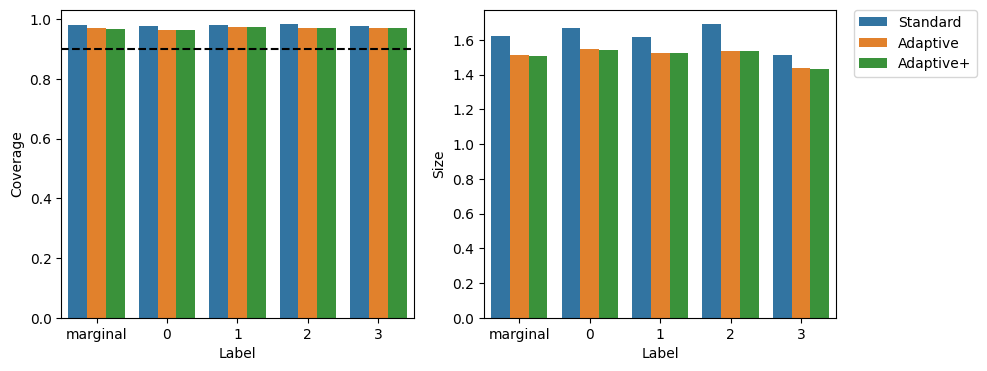

In [10]:
# Combine results
res_0['Method'] = "Standard"
res_1['Method'] = "Adaptive"
res_2['Method'] = "Adaptive+"
res = pd.concat([res_0, res_1, res_2])
res['Seed'] = random_state
res['Alpha'] = alpha

# Make plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

sns.barplot(data=res, x="Label", y="Coverage", hue='Method', ax=ax[0])
ax[0].axhline(1-alpha, color='black', linestyle='dashed')
ax[0].legend([],[], frameon=False)

sns.barplot(data=res, x="Label", y="Size", hue='Method', ax=ax[1])
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()